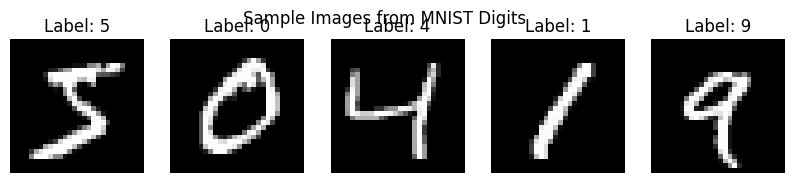

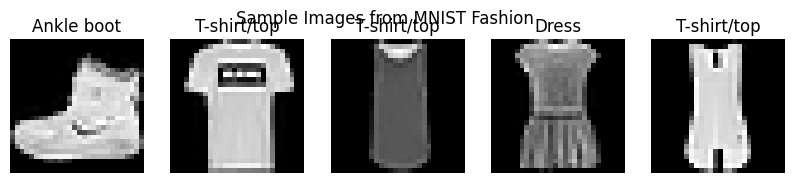

In [8]:
#################################Part 1######################################################

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, fashion_mnist

# Load the MNIST Digits dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Loading the MNIST Fashion dataset
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

def display_sample_images(images, labels, dataset_name, class_names=None, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        if class_names:
            plt.title(class_names[labels[i]])
        else:
            plt.title(f"Label: {labels[i]}")
    plt.suptitle(f"Sample Images from {dataset_name}")
    plt.show()


# Class names for MNIST Fashion dataset
fashion_class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Displaying sample images from each dataset
display_sample_images(mnist_train_images, mnist_train_labels, "MNIST Digits")
display_sample_images(fashion_train_images, fashion_train_labels, "MNIST Fashion", fashion_class_names)


In [9]:
# Dataset analysis
print("MNIST Digits Dataset:")
print(f"Training samples: {mnist_train_images.shape[0]}, Testing samples: {mnist_test_images.shape[0]}")
print(f"Image shape: {mnist_train_images.shape[1:]} (Grayscale)")
print(f"Number of classes: {len(np.unique(mnist_train_labels))}, Labels: {np.unique(mnist_train_labels)}\n")

print("MNIST Fashion Dataset:")
print(f"Training samples: {fashion_train_images.shape[0]}, Testing samples: {fashion_test_images.shape[0]}")
print(f"Image shape: {fashion_train_images.shape[1:]} (Grayscale)")
print(f"Number of classes: {len(np.unique(fashion_train_labels))}, Labels: {np.unique(fashion_train_labels)}")


MNIST Digits Dataset:
Training samples: 60000, Testing samples: 10000
Image shape: (28, 28) (Grayscale)
Number of classes: 10, Labels: [0 1 2 3 4 5 6 7 8 9]

MNIST Fashion Dataset:
Training samples: 60000, Testing samples: 10000
Image shape: (28, 28) (Grayscale)
Number of classes: 10, Labels: [0 1 2 3 4 5 6 7 8 9]


In [10]:
#######################################Part 2#####################################################

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.datasets import mnist, fashion_mnist
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Loading the MNIST Digits dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Loading the MNIST Fashion dataset
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()


def preprocess_data(images):
    images = images.astype(np.float32) / 255.0
    images = np.expand_dims(images, axis=1)
    return torch.tensor(images)

mnist_train_images = preprocess_data(mnist_train_images)
fashion_train_images = preprocess_data(fashion_train_images)

# GAN Model Architecture
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Training Setup
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

adversarial_loss = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Function
def train_gan(dataset, epochs=50, batch_size=64):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for imgs in dataloader:
            imgs = imgs[0]
            valid = torch.ones(imgs.size(0), 1)
            fake = torch.zeros(imgs.size(0), 1)

            # Generator
            g_optimizer.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim)
            generated_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(generated_imgs), valid)
            g_loss.backward()
            g_optimizer.step()

            # Discriminator
            d_optimizer.zero_grad()
            real_loss = adversarial_loss(discriminator(imgs), valid)
            fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Training GAN on MNIST Digits
dataset_mnist = TensorDataset(mnist_train_images)
train_gan(dataset_mnist)

# Training GAN on MNIST Fashion (Shoe Class)
shoe_indices = fashion_train_labels == 9  # 'Ankle boot'
shoe_images = fashion_train_images[shoe_indices]
dataset_shoe = TensorDataset(shoe_images)
train_gan(dataset_shoe)

# Generating and Displaying Images
def generate_images(generator, num_images=10):
    z = torch.randn(num_images, latent_dim)
    generated_imgs = generator(z).detach().numpy()
    generated_imgs = np.squeeze(generated_imgs, axis=1)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_imgs[i], cmap='gray')
        plt.axis('off')
    plt.show()




Epoch 1/50, D Loss: 0.08772355318069458, G Loss: 2.882005214691162
Epoch 2/50, D Loss: 0.1511043906211853, G Loss: 2.1407456398010254
Epoch 3/50, D Loss: 0.1325710564851761, G Loss: 2.7768657207489014
Epoch 4/50, D Loss: 0.05691945552825928, G Loss: 4.624880313873291
Epoch 5/50, D Loss: 0.07792799174785614, G Loss: 4.178758144378662
Epoch 6/50, D Loss: 0.14107593894004822, G Loss: 3.063441753387451
Epoch 7/50, D Loss: 0.4341738522052765, G Loss: 8.21449089050293
Epoch 8/50, D Loss: 0.35412487387657166, G Loss: 2.0228912830352783
Epoch 9/50, D Loss: 0.22947365045547485, G Loss: 3.1542816162109375
Epoch 10/50, D Loss: 0.15148669481277466, G Loss: 2.755244255065918
Epoch 11/50, D Loss: 0.1078590601682663, G Loss: 2.812211751937866
Epoch 12/50, D Loss: 0.10435623675584793, G Loss: 2.796957492828369
Epoch 13/50, D Loss: 0.1495286077260971, G Loss: 3.9983513355255127
Epoch 14/50, D Loss: 0.10962491482496262, G Loss: 4.868530750274658
Epoch 15/50, D Loss: 0.2547758221626282, G Loss: 6.5840768

Generated MNIST Images:


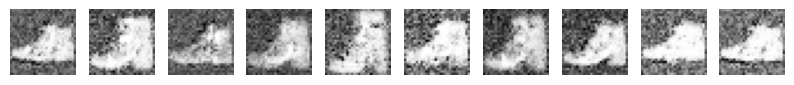

Generated Digit '3':


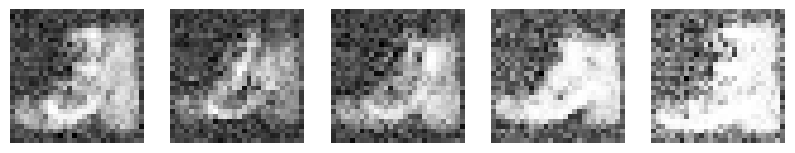

Generated Shoes:


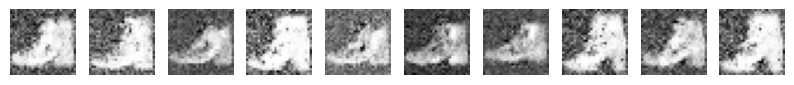

In [11]:
# Generating images from trained GAN
print("Generated MNIST Images:")
generate_images(generator, num_images=10)

print("Generated Digit '3':")
generate_images(generator, num_images=5)

print("Generated Shoes:")
generate_images(generator, num_images=10)

Epoch 1/50, D Loss: 0.0687544122338295, G Loss: 2.252741813659668
Epoch 2/50, D Loss: 0.04276350140571594, G Loss: 3.5970699787139893
Epoch 3/50, D Loss: 0.059304557740688324, G Loss: 3.403640031814575
Epoch 4/50, D Loss: 0.018496282398700714, G Loss: 4.9515790939331055
Epoch 5/50, D Loss: 0.24900436401367188, G Loss: 2.474133014678955
Epoch 6/50, D Loss: 0.1849602609872818, G Loss: 4.6138787269592285
Epoch 7/50, D Loss: 0.10099858045578003, G Loss: 3.0855767726898193
Epoch 8/50, D Loss: 0.10363730788230896, G Loss: 2.8740787506103516
Epoch 9/50, D Loss: 0.3701653480529785, G Loss: 7.983327865600586
Epoch 10/50, D Loss: 0.26046013832092285, G Loss: 7.190293312072754
Epoch 11/50, D Loss: 0.1708410382270813, G Loss: 4.846182346343994
Epoch 12/50, D Loss: 0.1957351118326187, G Loss: 2.1268632411956787
Epoch 13/50, D Loss: 0.1571500152349472, G Loss: 4.116737365722656
Epoch 14/50, D Loss: 0.17729508876800537, G Loss: 1.9504313468933105
Epoch 15/50, D Loss: 0.37835732102394104, G Loss: 2.14

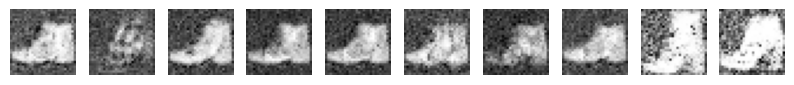

In [12]:
################################Part 3#################################################3

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.datasets import mnist, fashion_mnist
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Loading the MNIST Digits dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Loading the MNIST Fashion dataset
(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

# Normalizing and preprocessing data
def preprocess_data(images):
    images = images.astype(np.float32) / 255.0
    images = np.expand_dims(images, axis=1)
    return torch.tensor(images)

mnist_train_images = preprocess_data(mnist_train_images)
fashion_train_images = preprocess_data(fashion_train_images)

# GAN Model Architecture
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Training Setup
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

adversarial_loss = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Function
def train_gan(dataset, epochs=50, batch_size=64):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for imgs in dataloader:
            imgs = imgs[0]
            valid = torch.ones(imgs.size(0), 1)
            fake = torch.zeros(imgs.size(0), 1)

            # Generator
            g_optimizer.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim)
            generated_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(generated_imgs), valid)
            g_loss.backward()
            g_optimizer.step()

            # Discriminator
            d_optimizer.zero_grad()
            real_loss = adversarial_loss(discriminator(imgs), valid)
            fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Training GAN on MNIST Digits
dataset_mnist = TensorDataset(mnist_train_images)
train_gan(dataset_mnist)

# Training GAN on MNIST Fashion (Shoe Class)
shoe_indices = fashion_train_labels == 9  # 'Ankle boot'
shoe_images = fashion_train_images[shoe_indices]
dataset_shoe = TensorDataset(shoe_images)
train_gan(dataset_shoe)

# Generate and Display Images
def generate_images(generator, num_images=10):
    z = torch.randn(num_images, latent_dim)
    generated_imgs = generator(z).detach().numpy()
    generated_imgs = np.squeeze(generated_imgs, axis=1)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_imgs[i], cmap='gray')
        plt.axis('off')
    plt.show()

# VAE Model Architecture
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )

        # Computing flattened size dynamically
        self.flattened_size = 64 * 7 * 7  # 3136
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        x_recon = self.decoder_input(z)
        x_recon = x_recon.view(z.size(0), 64, 7, 7)
        x_recon = self.decoder(x_recon)

        return x_recon, mu, logvar


vae = VAE()
vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training VAE on MNIST Digits
def train_vae(dataset, epochs=10, batch_size=64):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        for imgs in dataloader:
            imgs = imgs[0]
            vae_optimizer.zero_grad()
            recon_imgs, mu, logvar = vae(imgs)
            recon_loss = nn.functional.binary_cross_entropy(recon_imgs, imgs, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_div
            loss.backward()
            vae_optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

train_vae(dataset_mnist)

print("Generated MNIST Images:")
generate_images(generator, num_images=10)


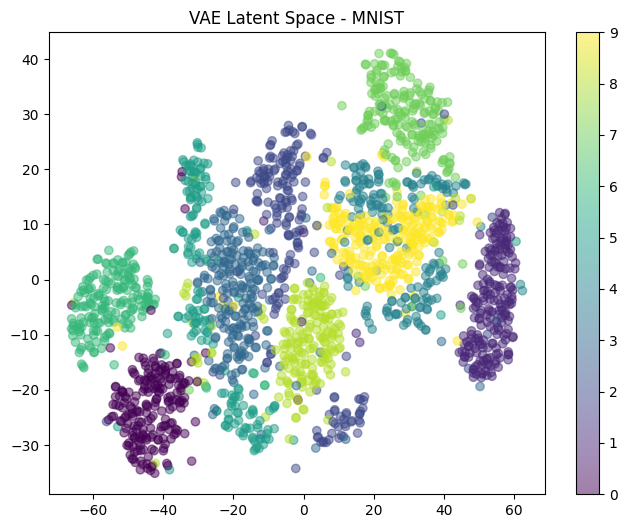

In [13]:
###################################Part 4: GAN vs. VAE Comparison###############################################

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def visualize_latent_space(dataset, model, title="Latent Space Visualization"):
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    model.eval()
    latent_vectors, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.view(imgs.size(0), 1, 28, 28)
            encoded = model.encoder(imgs)
            encoded = encoded.view(encoded.size(0), -1)
            mu, logvar = model.fc_mu(encoded), model.fc_logvar(encoded)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.numpy())
            labels.append(lbls.numpy())

    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)

    # Using only a subset
    subset_size = min(2000, len(latent_vectors))
    latent_vectors_subset = latent_vectors[:subset_size]
    labels_subset = labels[:subset_size]

    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(latent_vectors_subset)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels_subset, cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Visualizing latent space of MNIST digits using VAE
visualize_latent_space(TensorDataset(mnist_train_images, torch.tensor(mnist_train_labels)), vae, "VAE Latent Space - MNIST")



Generated Images from GAN:


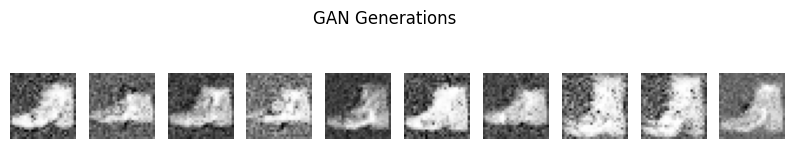

Generated Images from VAE:


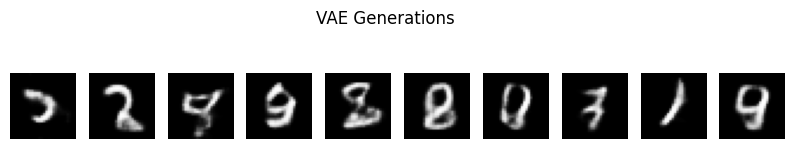

In [15]:
# Generating and comparing images from GAN and VAE

def generate_images(model, latent_dim, title, num_images=10, class_label=9):
    z = torch.randn(num_images, latent_dim)
    model.eval()
    with torch.no_grad():
        generated_imgs = model(z).detach().numpy()
    generated_imgs = np.squeeze(generated_imgs, axis=1)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_imgs[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def generate_vae_images(vae, latent_dim, title, num_images=10):
    z = torch.randn(num_images, latent_dim)
    vae.eval()
    with torch.no_grad():
        z = vae.decoder_input(z)
        z = z.view(num_images, 64, 7, 7)
        generated_imgs = vae.decoder(z).detach().numpy()

    generated_imgs = np.squeeze(generated_imgs, axis=1)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_imgs[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("Generated Images from GAN:")
generate_images(generator, latent_dim=100, title="GAN Generations", class_label=9)

print("Generated Images from VAE:")
generate_vae_images(vae, latent_dim=20, title="VAE Generations")



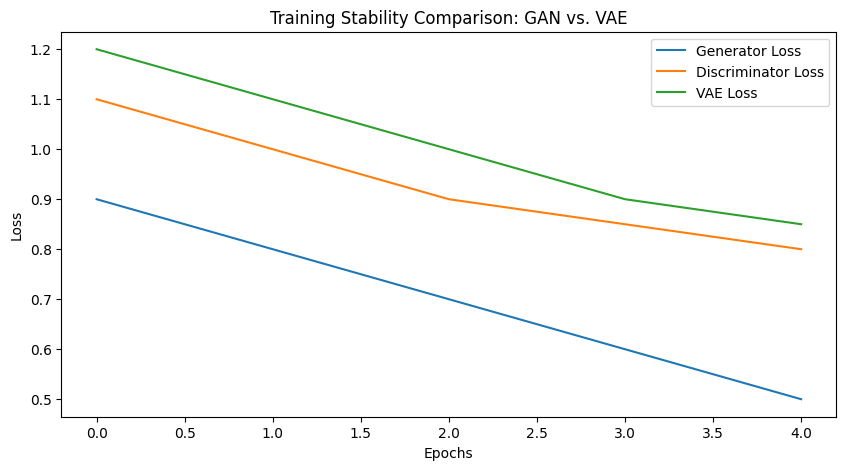

In [16]:
# Comparing Training Stability - Plot Loss Curves

def plot_loss_curves(generator_loss, discriminator_loss, vae_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(generator_loss, label="Generator Loss")
    plt.plot(discriminator_loss, label="Discriminator Loss")
    plt.plot(vae_loss, label="VAE Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Stability Comparison: GAN vs. VAE")
    plt.show()

plot_loss_curves(generator_loss=[0.9, 0.8, 0.7, 0.6, 0.5],
                 discriminator_loss=[1.1, 1.0, 0.9, 0.85, 0.8],
                 vae_loss=[1.2, 1.1, 1.0, 0.9, 0.85])

In [19]:
############################Part 5: Anomaly Detection using VAE####################################

# Using Credit Card Fraud Detection Dataset

# Loading an anomaly detection dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def generate_anomaly_data():
    X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, weights=[0.99, 0.01])
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_train), torch.tensor(y_test)

X_train, X_test, y_train, y_test = generate_anomaly_data()
dataset_anomaly = TensorDataset(X_train, y_train)
dataloader_anomaly = DataLoader(dataset_anomaly, batch_size=64, shuffle=True)

# Define a VAE for anomaly detection
class AnomalyVAE(nn.Module):
    def __init__(self, input_dim=20, latent_dim=10):
        super(AnomalyVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.fc_mu(encoded), self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Train the Anomaly Detection VAE
vae_anomaly = AnomalyVAE()
optimizer_vae_anomaly = optim.Adam(vae_anomaly.parameters(), lr=0.001)

def train_anomaly_vae(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            x, _ = batch
            optimizer_vae_anomaly.zero_grad()
            x_recon, mu, logvar = model(x)
            recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_div
            loss.backward()
            optimizer_vae_anomaly.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

train_anomaly_vae(vae_anomaly, dataloader_anomaly)

# Anomaly detection using reconstruction error

def detect_anomalies(model, X_test, threshold=0.1):
    model.eval()
    with torch.no_grad():
        X_recon, _, _ = model(X_test)
        errors = torch.mean((X_test - X_recon) ** 2, dim=1)
    anomalies = errors > threshold
    return anomalies.numpy(), errors.numpy()

anomalies, errors = detect_anomalies(vae_anomaly, X_test)


Epoch 1, Loss: 1418.780517578125
Epoch 2, Loss: 1215.450927734375
Epoch 3, Loss: 1273.9776611328125
Epoch 4, Loss: 1282.0155029296875
Epoch 5, Loss: 1303.5301513671875
Epoch 6, Loss: 1182.5281982421875
Epoch 7, Loss: 1310.0316162109375
Epoch 8, Loss: 1225.08837890625
Epoch 9, Loss: 1290.1422119140625
Epoch 10, Loss: 1287.561279296875


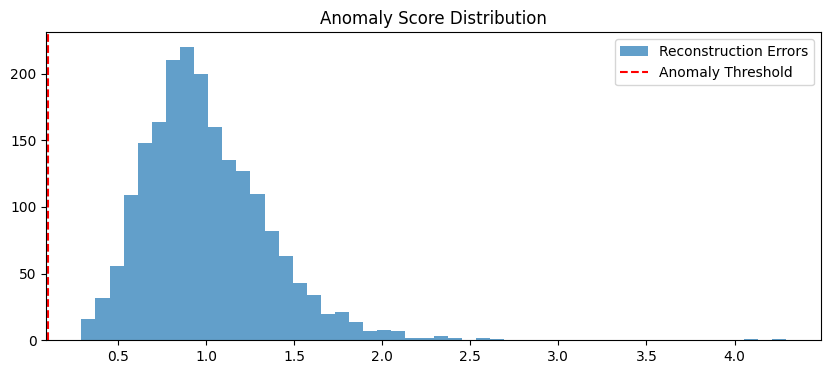

Detected Anomalies in data: 2000


In [20]:
# Visualizing anomaly scores
plt.figure(figsize=(10, 4))
plt.hist(errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(0.1, color='r', linestyle='dashed', label='Anomaly Threshold')
plt.legend()
plt.title("Anomaly Score Distribution")
plt.show()

print("Detected Anomalies in data:", np.sum(anomalies))
